# Problem 2 - Answers

In this problem, you will take the code developed for *method 3* in the previous problem, and modify it to simulate interacting particles in a box. We will not be implementing functionality for dealing with particle-particle or particle-wall collisions - instead we will work with repelling particles that are confined within a box by repulsive fields. The force describing interactions between particles is:

$$ \mathbf{F}_{ip} = \frac{A}{r^3} \exp{\left(\frac{-r}{K}\right)} \mathbf{r} $$

Each particle also experiences a force due to each of the four walls of the box:

$$ \mathbf{F}_{W} = \frac{B}{r_{\perp}^3} \exp{\left(\frac{-r_{\perp}}{L}\right)} \mathbf{r}_{\perp} $$

where $r_{\perp}$ is the perpendicular distance between the particle and the wall. 

This pairing of exponentially decaying repulsive potentials between particles and other particles, and between particles and the boundaries, is used in modelling a range of physical situations from a crowd moving through a corridor to charged dust particles in a plasma. 

## Setup

a) Modify your initialise function so that the initial positions are not totally random, but are instead guaranteed to all be initially a certain distance apart (this is to prevent numerical issues caused by particles initially being on top of each other). You could do this by sampling initial positions from a grid. You should also change the initial velocities from zeros to being sampled from a normal distribution. The standard deviation of this distribution should be an argument to the function.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist,squareform
from IPython.display import HTML
import time

n = 81
dt = 0.001
A = 1
B = 10
K = 0.1
L = 0.1

def initialise(n,stdev=1.0):
    poslist = []
    vellist = []
    n_upper = np.ceil(np.sqrt(n))
    for i in range(n):
        poslist.append(1/(n_upper+1)*np.array([i//n_upper+1,i%n_upper+1]))
        vellist.append(np.random.normal(0.0,stdev,size=(2)))
    pos = np.array(poslist)
    vel = np.array(vellist)
    return pos,vel

b) Adapt your method3 function to implement the above particle-particle and particle-wall forces. Rename this function `step`.

In [2]:
def step(n,pos,vel):
    
    dX = np.zeros((n,n))
    dY = np.zeros((n,n))

    for i in range(1,n):
        dX.flat[i:n*(n-i):n+1] = (pos[:n-i,0] - pos[i:,0]).flat
        dY.flat[i:n*(n-i):n+1] = (pos[:n-i,1] - pos[i:,1]).flat

    # calculate distances and get the matrix of force magnitudes
    norms = np.sqrt(dX**2 + dY**2)
    C = np.zeros((n,n))
    C[norms!=0] = -1 / norms[norms!=0]**3 * np.exp(-norms[norms!=0]/K)

    # multiply displacements by force magnitudes to get force vectors
    dX *= C
    dY *= C
    
    # make the matrices antisymmetric
    dX += -1 * np.rot90(np.fliplr(dX))
    dY += -1 * np.rot90(np.fliplr(dY))
    
    # Sum particle-particle forces to get 2D force vector
    Fip = np.vstack([np.sum(dX,axis=0),np.sum(dY,axis=0)]).T
    
    # Calculate forces due to walls at X=0,1 and Y=0,1
    FW = B*(np.exp((-pos)/L)/(pos)**2 - np.exp((pos-1)/L)/(pos-1)**2)

    # Euler step
    vel += (Fip + FW) * dt
    pos += vel * dt
    
    return pos,vel    


c) Make an animation of how a system of 100 particles evolves over 100 time steps. Check that this behaves as you would expect.

In [3]:
def animate(pos,vel,n,nstep,interval=20):
    fig,ax = plt.subplots()
    plt.close(fig)
    ax.set_aspect(aspect=1.0)
    ln, = ax.plot(pos[:,0],pos[:,1],'ro')
    data = []
    for i in range(nstep):
        pos,vel = step(n,pos,vel)
        data.append(pos.copy())
    def init():
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        return ln,
    
    def update(i):
        ln.set_data(data[i][:,0],data[i][:,1])
        return ln,
        
    anim = FuncAnimation(fig,update,frames=range(nstep),init_func=init,blit=True,interval=interval)
    return HTML(anim.to_jshtml())

pos,vel = initialise(100)
animate(pos,vel,n=100,nstep=100,interval=100)

## Measuring Pressure

The pressure that is exerted on each wall of the box due to interactions with the particles may be found by summing over the particle-wall forces.

a) Modify your `step` function to calculate the total force exerted on each wall. As the walls have unit length, this is identical to the pressure on the wall. `step` should return the sum of the pressures on each wall (as well as the updated positions and velocities).

In [4]:
def step(n,pos,vel):
    
    dX = np.zeros((n,n))
    dY = np.zeros((n,n))

    for i in range(1,n):
        dX.flat[i:n*(n-i):n+1] = (pos[:n-i,0] - pos[i:,0]).flat
        dY.flat[i:n*(n-i):n+1] = (pos[:n-i,1] - pos[i:,1]).flat

    # calculate distances and get the matrix of force magnitudes
    norms = np.sqrt(dX**2 + dY**2)
    C = np.zeros((n,n))
    C[norms!=0] = -1 / norms[norms!=0]**3 * np.exp(-norms[norms!=0]/K)

    # multiply displacements by force magnitudes to get force vectors
    dX *= C
    dY *= C
    
    # make the matrices antisymmetric
    dX += -1 * np.rot90(np.fliplr(dX))
    dY += -1 * np.rot90(np.fliplr(dY))
    
    # Sum particle-particle forces to get 2D force vector
    Fip = np.vstack([np.sum(dX,axis=0),np.sum(dY,axis=0)]).T
    
    # Calculate forces due to walls at X=0,1 and Y=0,1
    FW = B*(np.exp((-pos)/L)/(pos)**2 - np.exp((pos-1)/L)/(pos-1)**2)

    # Calculate the total pressure by summing over the forces on each wall
    P = np.mean([np.sum(B*(np.exp((-pos[:,0])/L))),
              np.sum(B*(np.exp((pos[:,0]-1)/L))),
              np.sum(B*(np.exp((-pos[:,1])/L))),
              np.sum(B*(np.exp((pos[:,1]-1)/L)))])
    
    # Euler step
    vel += (Fip + FW) * dt
    pos += vel * dt
    
    return pos,vel,P

b) Run your simulation of 100 particles for 1000 time steps. Plot how the pressure changes over this time. 

Text(0, 0.5, 'P')

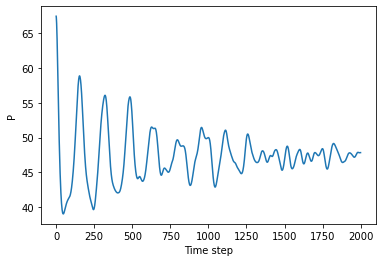

In [5]:
Ps = []
pos,vel = initialise(100)
for i in range(2000):
    pos,vel,P = step(100,pos,vel)
    Ps.append(P)
plt.plot(Ps)
plt.xlabel('Time step')
plt.ylabel('P')

c) You should find that after some time the system comes to an equilibrium and the pressure oscillates about some mean value. Define a function `pressure` that takes two arguments: the number of particles, and the standard deviation of the random distribution of particle speeds. It should return the mean pressure.

In [6]:
def pressure(n,stdev):
    Ps = []
    pos,vel = initialise(n,stdev)
    for i in range(10000):
        pos,vel,P = step(n,pos,vel)
        Ps.append(P)
    return np.mean(Ps[1000:])

d) Use your  `pressure` function make a plot of how pressure varies with the number of particles in the box. Does it vary as you expect? Extract parameter(s) to characterise the dependence. 

Text(0, 0.5, 'P')

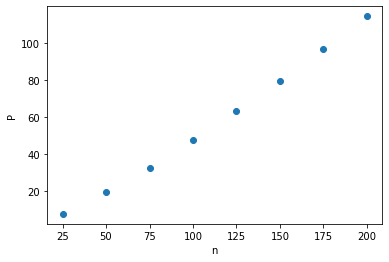

In [7]:
ns = [25,50,75,100,125,150,175,200]
Ps = []
for n in ns:
    Ps.append(pressure(n,1.0))
plt.plot(ns,Ps,'o')
plt.xlabel('n')
plt.ylabel('P')

e) Now make a plot of how pressure varies with the typical speed of particles in the box. Does it vary as you expect? Extract parameter(s) to characterise the dependence. 

Text(0, 0.5, 'P')

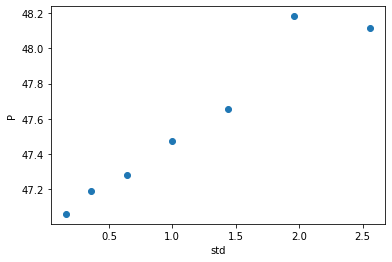

In [8]:
stds = [0.4,0.6,0.8,1.0,1.2,1.4,1.6]
Ps = []
for std in stds:
    Ps.append(pressure(100,std))
plt.plot(np.array(stds)**2,Ps,'o')
plt.xlabel('std')
plt.ylabel('P')